In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.ndimage
import seaborn as sns
from PIL import Image

ModuleNotFoundError: No module named 'scripts.utils'

# Pallial Spatial Representations

This notebook collates high-level analysis approaches after df/f extraction. For now, I assume the following data structure for datasets collected in a folder *processed_datasets*:
```
processed_datasets/
├── yyyymmdd_Area_AcqNr/
│   ├── yyyymmdd_Area_AcqNr_dff.pkl
│   ├── yyyymmdd_Area_AcqNr_behavior.pkl
│   ├── yyyymmdd_Area_AcqNr_anatomy.tif
│   ├── yyyymmdd_Area_AcqNr_masks.png
│   ├── yyyymmdd_Area_AcqNr_cm.tif
```

To do: 
- incorporate also the dataset for the full behavioral analysis, so that it is possible to extract from which trial and experimental stage any given imaging data is obtained from

Goals:
- Computational measure for place coding
- Distribution of place fields over corridors
- Dependence on experimental stage (social reinforcement vs spatial cues only)
- Visualize neurons with high spatial information in the anatomy
- Try and decode location from population activity

I will start by implementing spatial information measures described in [Yang, C. et al., *A population code for spatial representation in the zebrafish telencephalon*, **Nature 1-10 (2024)** doi:10.1038/s41586-024-07867-2](https://www.nature.com/articles/s41586-024-07867-2#Sec21): 

*A spatial activity map was generated for each neuron, representing the mean neural activity at each spatial location. To calculate the spatial activity map the chamber was divided into square bins (side length 1.2 mm) and then the summed neural activity and occupancy time were calculated for each bin. This resulted in two matrices: a summed neural activity matrix and an occupancy matrix (matrix entries correspond to spatial bins). We then applied a boundary-constrained Gaussian filter (standard deviation one bin, with the boundary defined by the chamber boundary) to these two matrices. The spatial activity map was calculated by dividing the filtered summed neural activity matrix by the filtered occupancy matrix to obtain the filtered average activity in each spatial bin. When the fish was stationary (speed below 0.1 mm/s), the corresponding frames were not included in the calculation of the spatial activity map. For all experimental spatial activity maps (for example, for comparison of spatial maps across sessions) we exclude the first 15 min following initial exposure to the environment in S1. For within-session control (comparison between the first and second halves of S1) we separately generated spatial activity maps for the first and second halves of S1. The first 15 min were not excluded in the within-session control, to ensure sufficient coverage of the environment by the fish trajectory.*

*From the spatial activity map of each cell, spatial information can be used to quantify how much information is contained by that cell about the location of the animal, in units of bits per seconds. For each cell, spatial information I was calculated as*

$I = \sum_{x} \lambda(x) log_{2} \frac{\lambda(x)}{\lambda}P(x)$, 

*where x is a spatial bin, P(x) is the probability that the fish is in the spatial bin x, $\lambda(x)$ is the mean activity of the cell when the fish is in spatial bin x and $\lambda$ is average neural activity, computed as $\lambda = \sum_{x}\lambda(x)P(x)$.*

*Based on the equation above, cells with high average neural activity tend to have higher spatial information. To normalize for this we calculate specificity s as*

$ s = \frac{I}{\lambda}$

  

In [3]:
# util functions to go from .pkl dataframes to average activity in each spatial bin. 
# Also stationary frames are included as of now. 

def load_data(file_path: Path):
    dff = pd.read_pickle(sorted(file_path.glob("*dff.pkl"))[0])
    behavior = pd.read_pickle(sorted(file_path.glob("*behavior.pkl"))[0])
    return dff, behavior

def remove_interpolated_values(behavior, n_corr=2):
    '''
    Cleans up interpolated X values by reassigning them to the nearest valid corridor value in time order.

            Parameters:
                    behavior (pandas.core.frame.DataFrame): contains X, Y columns with spatial information
                    n_corr (int): number of corridors to consider (defaults to 2)

            Returns:
                    behavior (pandas.core.frame.DataFrame): cleaned behavior data with X values reassigned
    '''
    # Get the most common corridor values
    corr_val = behavior['X'].value_counts().head(n_corr).index.values

    # Replace invalid X values with the next valid value in the time sequence
    last_valid_value = None
    for i in range(len(behavior)):
        if behavior.loc[i, 'X'] not in corr_val:
            if last_valid_value is not None:
                behavior.loc[i, 'X'] = last_valid_value
        else:
            last_valid_value = behavior.loc[i, 'X']
    
    return behavior
    

def subsample(dff, behavior, actual_rate = 30, sampled_rate = 7.5):    
    pass
    
def binning(dff, behavior, n_bins = 10, n_corr = 2, firing_rate = 30):
    '''
    Bins occupancy and activity data. Assumes that corridors have been completely sampled by the animal. 
    Assumes that distinct corridors are characterized by X position.

            Parameters:
                    dff (pandas.core.frame.DataFrame): df/f calcium imaging data (rows: time; columns: neurons)
                    behavior (pandas.core.frame.DataFrame): contains X, Y columns with spatial information and frdIn with tail vigor
                    n_bins (int): number of bins, defaults to 10 
                    n_corr (int): number of corridors, defaults to 2

            Returns:
                    time_per_bin (pandas.core.frame.DataFrame): time spent in each bin, n_bins x n_corridors
                    summed_traces (pandas.core.frame.DataFrame): summed activity for each bin, n_bins x n_corridors x n_neurons
    '''
    # Create bin labels and cut the Y positions into bins
    behavior['Y_bin'] = pd.cut(behavior['Y'], bins=n_bins, labels=False)
    behavior['X_bin'] = pd.cut(behavior['X'], bins = len(behavior.X.unique()))
    
    # Group by the corridor ID (X position) and Y-bin, and calculate the time per bin
    time_per_bin = behavior.groupby(['X_bin', 'Y_bin'], observed=False).size().unstack(fill_value=0)
    
    # Automatically generate column names based on the number of corridors
    num_corridors = time_per_bin.shape[0]
    column_names = [f"Corridor_{i+1}" for i in range(num_corridors)]
    time_per_bin = pd.DataFrame(time_per_bin.T.values, columns=column_names) / firing_rate
    
    # Sum calcium traces for each bin and corridor
    summed_traces = (
        behavior[['X', 'Y_bin']]
        .join(dff, how='left')
        .groupby(['X', 'Y_bin'])
        .sum()
        .unstack(level=0, fill_value=0)
    )
    
    # Make column and row names intuitive:
    summed_traces.rename_axis("Space bin", inplace=True)
    summed_traces.columns.set_names(["Neuron", "Corridor"], inplace=True)
    #summed_traces.convert_dtypes().dtypes # hard conversion
    summed_traces.apply(pd.to_numeric).dtypes
    
    return time_per_bin, summed_traces
    
def avg_activity(time_per_bin, summed_traces):
    '''
    Devides summed neural activity matrix by the occupancy matrix to obtain the average activity in each spatial bin.
    
            Parameters:
                    time_per_bin (pandas.core_frame.DataFrame): time spent in each bin, n_bins x n_corridors
                    summed_traces (pandas.core.frame.DataFrame): summed activity for each bin, n_bins x n_corridors x n_neurons
            Returns:
                    avg_activity_mtx (pandas.core_frame.DataFrame): average activity in each spatial bin.
    '''
    # Create an empty DataFrame with the same structure as summed_traces
    avg_activity_mtx = pd.DataFrame(index=summed_traces.index, columns=summed_traces.columns)

    # Iterate through each neuron column group (level 1 in the MultiIndex)
    for neuron in summed_traces.columns.get_level_values("Neuron").unique():
        trace = summed_traces[neuron].apply(pd.to_numeric)
        # Apply the division by the time occupancy for each neuron and assign to the new DataFrame
        avg_activity_mtx[neuron] = (
            trace.div(time_per_bin.values, axis=0)
        )
    
    return avg_activity_mtx

def spatial_info_calc(avg_activity_mtx, time_per_bin):
    '''
    Calculates the spatial information for each neuron based on the average activity in spatial bins and occupancy probability.

        Parameters:
            avg_activity_mtx (pandas.core_frame.DataFrame): average activity in each spatial bin (MultiIndex: Neuron, Corridor).
            time_per_bin (pandas.core_frame.DataFrame): time spent in each spatial bin (n_bins x n_corridors).

        Returns:
            spatial_info (pandas.Series): spatial information for each neuron, indexed by neuron ID.
            spatial_spec (pandas.Series): spatial specificity for each neuron, indexed by neuron ID.
    '''
    P_x = time_per_bin / time_per_bin.sum().sum()
    # Initialize a Series to store spatial information for each neuron
    spatial_info = pd.Series(index=avg_activity_mtx.T.index.get_level_values("Neuron").unique(), dtype=float)
    spatial_spec = spatial_info.copy(deep=True)
    # Iterate through each neuron
    for neuron in spatial_info.index:
        neuron_activity = avg_activity_mtx.T.loc[neuron]
        lambda_avg = (neuron_activity * P_x.T.values).sum().sum()
        data = neuron_activity / lambda_avg
        valid_data = data[data > 0].dropna()
        I = np.nansum(neuron_activity * np.log2(valid_data) * P_x.T.values)
        spatial_info[neuron] = I
        spatial_spec[neuron] = I / lambda_avg

    return spatial_info, spatial_spec

def spec_z_score(dff, behavior, sampling_rate=30, n_permut=1000, n_bins=10):
    '''
    Calculates specificity z-score by circularly permutating activity & behavioral data. From this shifted data,
    a null distribution of specificity scores is computed. The specificity z-score is then calculated by subtracting
    the mean of this distribution and dividing by its standard deviation.
    
    Parameters:
        dff (DataFrame): dF/F activity data.
        behavior (DataFrame): Behavioral data to be shifted.
        sampling_rate (int): Sampling rate of the data (default: 30).
        n_permut (int): Number of permutations (default: 1000).
        n_bins (int): Number of spatial bins (default: 10).
    
    Returns:
        actual_spatial_spec (float): Actual specificity score.
        shifted_spec (list): List of specificity scores from permuted data.
    '''
    # Create an empty list to store specificity scores
    shifted_spec = []

    # Iterate through shifts, creating a null distribution
    for i in range(int(-(n_permut // 2)), int((n_permut // 2) + 1)):
        shift_amount = (i * sampling_rate) // 2  # 500 ms shifts

        # Safely circularly shift the behavior data
        shift_amount = shift_amount % len(behavior)
        if shift_amount != 0:
            shifted_behavior = pd.concat([behavior.iloc[-shift_amount:], behavior.iloc[:-shift_amount]]).reset_index(drop=True)
        else:
            shifted_behavior = behavior.copy()

        # Calculate specificity score for the shifted data
        time_per_bin, summed_traces = binning(dff, shifted_behavior, n_bins = n_bins)
        avg_act_mtx = avg_activity(time_per_bin, summed_traces)
        spatial_info, spatial_spec = spatial_info_calc(avg_act_mtx, time_per_bin)
        shifted_spec = [spec for spec in shifted_spec if not spec.isna().any() and not np.isinf(spec).any()]

        # Collect shifted specificity scores, exclude shift_amount = 0
        if shift_amount != 0:
            shifted_spec.append(spatial_spec)
        else:
            actual_spatial_spec = spatial_spec
            
    return (actual_spatial_spec - pd.DataFrame(shifted_spec).mean()) / pd.DataFrame(shifted_spec).std()

def pop_z_score(spatial_spec):
    std_dev = spatial_spec.std()
    if std_dev == 0:
        return pd.Series(np.nan, index=spatial_spec.index)
    return (spatial_spec - spatial_spec.mean()) / std_dev

   
def trials_over_time(neuron_ID, dff, behavior, n_bins=10, export_figure=False):
    '''
    For any given neuron ID, this plots the activity per spatial bin per corridor per trial in two heatmaps
    with shared color scales and consistent x-axis (spatial bins).
    
    Parameters:
        neuron_ID (int): column number of neuron in dff.
        dff (DataFrame): dF/F activity data in timepoints (rows) x neurons (columns).
        behavior (DataFrame): Behavioral data in timepoints (rows) x behavior (column).
        n_bins (int): number of spatial bins to plot (defaults to 10).
        export_figure (boolean): defines whether plot should be saved (defaults to False).
    '''

    # Step 1: Extract neuron activity
    neuron_activity = dff.iloc[:, neuron_ID]

    # Step 2: Create spatial bins for the Y-position
    behavior['Y_bin'] = pd.cut(behavior['Y'], bins=n_bins, labels=False)

    # Step 3: Separate trials and corridors
    trials = behavior['trial'].unique()
    corridors = behavior['X'].unique()

    # Create a dictionary to store binned activity for each corridor
    binned_activity = {corridor: [] for corridor in corridors}

    # Step 4: Iterate over trials and bin activity for each corridor
    for trial in trials:
        trial_data = behavior[behavior['trial'] == trial]
        trial_activity = neuron_activity.loc[trial_data.index]

        for corridor in corridors:
            corridor_data = trial_data[trial_data['X'] == corridor]
            corridor_activity = trial_activity.loc[corridor_data.index]

            # Bin the activity by spatial bins
            avg_activity_per_bin = corridor_activity.groupby(corridor_data['Y_bin']).mean()

            # Ensure all spatial bins (0 to n_bins-1) are present
            avg_activity_per_bin = avg_activity_per_bin.reindex(range(n_bins), fill_value=np.nan)
            binned_activity[corridor].append(avg_activity_per_bin)

    # Step 5: Convert lists to DataFrames for heatmap plotting
    heatmap_data_corridor_1 = pd.DataFrame(binned_activity[corridors[0]])
    heatmap_data_corridor_2 = pd.DataFrame(binned_activity[corridors[1]])

    # Step 6: Determine shared color scale limits
    vmin = min(heatmap_data_corridor_1.min().min(), heatmap_data_corridor_2.min().min())
    vmax = max(heatmap_data_corridor_1.max().max(), heatmap_data_corridor_2.max().max())

    # Step 7: Plot heatmaps with shared color scale and consistent x-axis
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    sns.heatmap(heatmap_data_corridor_1, cmap='magma', ax=axes[0], vmin=vmin, vmax=vmax, cbar=True)
    axes[0].set_title(f"Corridor {corridors[0]}")
    axes[0].set_xlabel("Spatial Bin")
    axes[0].set_ylabel("Trial")
    axes[0].set_xticks(np.arange(n_bins))
    axes[0].set_xticklabels(np.arange(n_bins))

    sns.heatmap(heatmap_data_corridor_2, cmap='magma', ax=axes[1], vmin=vmin, vmax=vmax, cbar=True)
    axes[1].set_title(f"Corridor {corridors[1]}")
    axes[1].set_xlabel("Spatial Bin")
    axes[1].set_xticks(np.arange(n_bins))
    axes[1].set_xticklabels(np.arange(n_bins))

    plt.tight_layout()
    if export_figure:
        plt.savefig(f"neuron_{neuron_ID}_plot.svg")    
    plt.show()

def add_trial_column(behavior):
    '''
    Adds a "trial" column to the behavior DataFrame based on Y-position resets (teleports).
    
    Parameters:
        behavior (DataFrame): Behavioral data containing the Y column (position).
    
    Returns:
        behavior (DataFrame): Updated DataFrame with a new "trial" column.
    '''
    # Initialize the trial counter and create an empty list for trial numbers
    trial_counter = 0
    trial_numbers = []

    # Iterate through the Y-position data
    for i in range(len(behavior)):
        # Check if the current Y position is 0 and the previous Y position was non-zero
        if i > 0 and behavior.loc[i, 'Y'] == 0 and behavior.loc[i - 1, 'Y'] != 0:
            # Increment the trial counter
            trial_counter += 1

        # Assign the current trial number
        trial_numbers.append(trial_counter)

    # Add the trial column to the DataFrame
    behavior['trial'] = trial_numbers

    return behavior

Defining place fields. The place field (PF, or firing field) of each neuron is defined as the set of spatial bins with activity above 80% of peak activity (with peak defined as the 95th percentile) of the spatial activity map. A more in-depth and systematic analysis of unimodal and multimodal PFs is described in Extended Data Fig. 1i–k, in which the activity threshold was swept from 50 to 80%. The location of the PF is represented by its center of mass (COM) for cells with a single PF. For cells with multiple PFs (as distinct components in the map) we use the COM of the component(over 20 bins, to avoid spurious PFs due to noise), with the highest peak activity (defined as the 95th percentile of the component) as the location of its primary PF. Only PCs with a PF size of less than 30% of chamber size are included in maps of the distribution of PFs and in the analysis of PF shift. PFs are used only for analysis of PF shift and visualization of PF location across an environment. All other analyses of PC activity, such as PF correlation, PV correlation, change in specificity and positional decoding, use the spatial activity map directly.

In [4]:
def place_field_size(avg_activity_mtx, neuron_ID, n_bins=30, chamber_size=150): # FIXME
    '''
    Calculates the place fields of bona fide place cells and returns their center of mass as well as their size.
    
    Parameters: 
        avg_activity_mtx (DataFrame): Average activity in each spatial bin (MultiIndex: Neuron, Corridor).
        neuron_ID (array): List of bona fide place cells to be used for indexing.
        n_bins (int): Number of spatial bins (default: 30).
        chamber_size (int): Size of the chamber in VR units (default: 150).
    
    Returns:
        pf_list (list of dicts): List of dictionaries with the size and center of mass of the place fields for each neuron.
    '''
    pf_list = []

    # Iterate over each neuron in the provided list
    for neuron in neuron_ID:
        neuron_data = avg_activity_mtx.T.xs(neuron, level='Neuron')

        # Step 1: Determine the peak activity (95th percentile) for the neuron
        peak_activity = np.percentile(neuron_data.values, 95)

        # Step 2: Define the place field threshold (80% of the peak activity)
        threshold = 0.8 * peak_activity
        
        # Step 3: Identify place fields as contiguous regions above the threshold
        place_fields = []
        for corridor in neuron_data.T.columns:
            activity = neuron_data[corridor].values
            above_threshold = activity > threshold

            # Find contiguous bins above the threshold
            place_field_bins = []
            current_field = []
            for idx, is_above in enumerate(above_threshold):
                if is_above:
                    current_field.append(idx)
                elif current_field:
                    # Append and reset the current field
                    place_field_bins.append(current_field)
                    current_field = []

            # Check the last field
            if current_field:
                place_field_bins.append(current_field)

             # Step 4: Calculate the COM and size for each place field
            for pf in place_field_bins:
                pf_size = len(pf) / n_bins * chamber_size
                #if pf_size < 0.3 * chamber_size:  # Filter by size (less than 30% of chamber size)
                #pf_com = center_of_mass(activity[pf])
                place_fields.append({'size': pf_size})

        # Step 5: Store the results for the current neuron
        pf_list.append({
            'neuron': neuron,
            'place_fields': place_fields
        })

    return pf_list


In [4]:
### test for above function
#neuron_ID = 18
#neuron_data = avg_act_mtx.T.xs(neuron_ID, level='Neuron')
#peak_activity = np.percentile(neuron_data.values, 95)
#threshold = 0.8 * peak_activity
#neuron_data.T[neuron_data.T.columns[0]].values > threshold

#sns.heatmap(neuron_data)

Given a list of neurons with a sufficiently high spatial specificity to be counted as bona fide place cells, we want to highlight where they are found within the recorded area. For this, the index of place cells has to be passed to the neuron mask and superimposed on the anatomy of the recorded area. 
```
│   ├── yyyymmdd_Area_AcqNr_anatomy.tif
│   ├── yyyymmdd_Area_AcqNr_masks.png
│   ├── yyyymmdd_Area_AcqNr_cm.tif
```

In [5]:
def load_anatomy(file_path: Path):
    anatomy_path = sorted(file_path.glob("*_anatomy.tif"))[0]
    mask_path = sorted(file_path.glob("*_masks.png"))[0]
    #correlation_map_path = sorted(file_path.glob("*_cm.tif"))[0]
    anatomy = np.array(Image.open(anatomy_path))
    mask = np.array(Image.open(mask_path))
    #correlation_map = np.array(Image.open(correlation_map_path))
    return anatomy, mask#, correlation_map

def plot_neurons(file_path: Path, neuron_index: np.ndarray, spec_df, save_figure=False):
    '''
    Plots the spatial specificity of bona fide place cells in the anatomical context, with three subplots:
    1. Spatial specificity
    2. Specificity Z-score
    3. Population Z-score
    
    Parameters:
        file_path (Path): path to the folder containing all files for a given dataset.
        neuron_index (array): list of indices for place cells.
        spec_df (DataFrame): DataFrame with columns "spatial_specificity", "specificity_zscore", and "population_zscore".
        save_figure (boolean): Whether the figure should just be printed or also saved.
    Returns:
        None
    '''
    # Load the anatomical data
    anatomy, mask = load_anatomy(file_path)

    # Prepare figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharex=True, sharey=True)
    subplot_titles = ["Spatial Specificity", "Specificity Z-Score", "Population Z-Score"]
    columns = ["spatial_specificity", "specificity_zscore", "population_zscore"]
    color_maps = ["inferno", "inferno", "inferno"] # plasma, viridis,...

    # Iterate over subplots
    for ax, title, col, cmap in zip(axes, subplot_titles, columns, color_maps):
        # Plot the anatomical correlation map as background
        ax.imshow(anatomy, cmap='gray', aspect='auto')
        ax.set_title(title)
        ax.axis("off")

        # Get the values for color-coding
        values = spec_df.loc[neuron_index, col]

        # Normalize the values for color mapping
        norm = plt.Normalize(values.min(), values.max())

        # Plot each neuron, color-coded by the column value
        for neuron_id, value in zip(neuron_index, values):
            # Get the mask coordinates for the current neuron
            y_coords, x_coords = np.where(mask == neuron_id + 1)  # Mask indices are 1-based

            # Plot the neuron with the color corresponding to its value
            if len(y_coords) > 0:
                ax.scatter(x_coords, y_coords, s=5, color=plt.get_cmap(cmap)(norm(value)))
                # Draw an outline around the neuron
                neuron_mask = (mask == neuron_id + 1).astype(int)
                ax.contour(neuron_mask, levels=[0.5], colors='white', linewidths=1.5)

        # Add a color bar to the subplot
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)

    # Adjust layout
    plt.tight_layout()

    # Save or show the figure
    if save_figure:
        save_path = file_path / "place_cells_spatial_specificity_subplots.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        save_path_svg = file_path / "place_cells_spatial_specificity_subplots.svg"
        plt.savefig(save_path_svg)
        print(f"Figure saved to {save_path}")
    else:
        plt.show()

    plt.close()
    
    

In [6]:
dff, bh = load_data(Path('W:\\scratch\\gfriedri\\anneluka\\Experiments\\VirtualReality\\data\\processed_datasets\\20240903_Dc_1\\'))
bh = remove_interpolated_values(bh, n_corr=2)
time_per_bin, summed_traces = binning(dff, bh, n_bins=30)
avg_act_mtx = avg_activity(time_per_bin, summed_traces)
spatial_info, spatial_spec = spatial_info_calc(avg_act_mtx, time_per_bin)

spec_z_score_values = spec_z_score(dff, bh, n_permut=100, n_bins=30)
pop_z_score_values = pop_z_score(spatial_spec)

df = pd.DataFrame({"spatial_specificity": spatial_spec, 
 "specificity_zscore": spec_z_score_values,
 "population_zscore": pop_z_score_values})

indices = df[(df["specificity_zscore"] > 1) & (df["population_zscore"] > 1)].index.to_numpy()
indices

array([1, 6, 8, 13, 17, 18, 20, 21, 42, 45, 52, 58, 59, 72, 73, 81, 83,
       99, 106, 112, 129, 136, 153, 172, 179, 188, 195, 197, 198, 204,
       210, 211, 232, 254, 275, 278, 285, 286, 292, 301, 311, 318, 320,
       321, 329, 337, 338, 346], dtype=object)

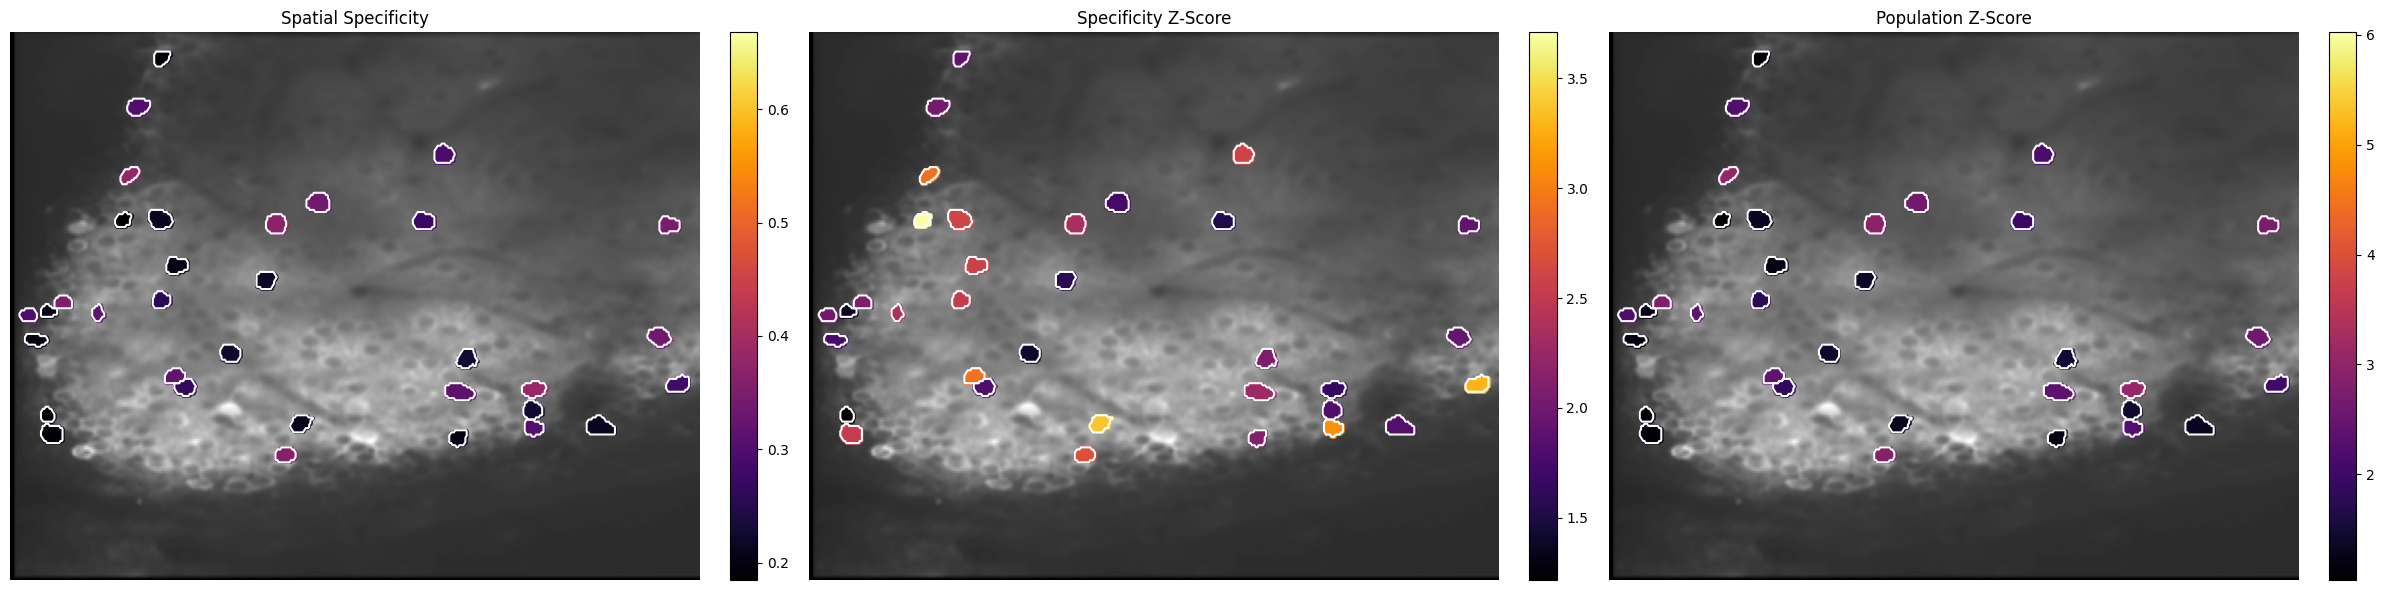

In [7]:
plot_neurons(Path('W:\\scratch\\gfriedri\\anneluka\\Experiments\\VirtualReality\\data\\processed_datasets\\20241203_Dl_1\\'),
            indices, df)

#plot_neurons(Path('W:\\scratch\\gfriedri\\anneluka\\Experiments\\VirtualReality\\data\\processed_datasets\\20240903_Dc_1\\'),
#            [318], df, save_figure=False)

#plot_neurons(Path('W:\\scratch\\gfriedri\\anneluka\\Experiments\\VirtualReality\\data\\processed_datasets\\20241203_Dc\\'),
#            list(range(1, 288)), df) , 81, 210, 292, 318

In [89]:
list(range(1, 280))[0]

1

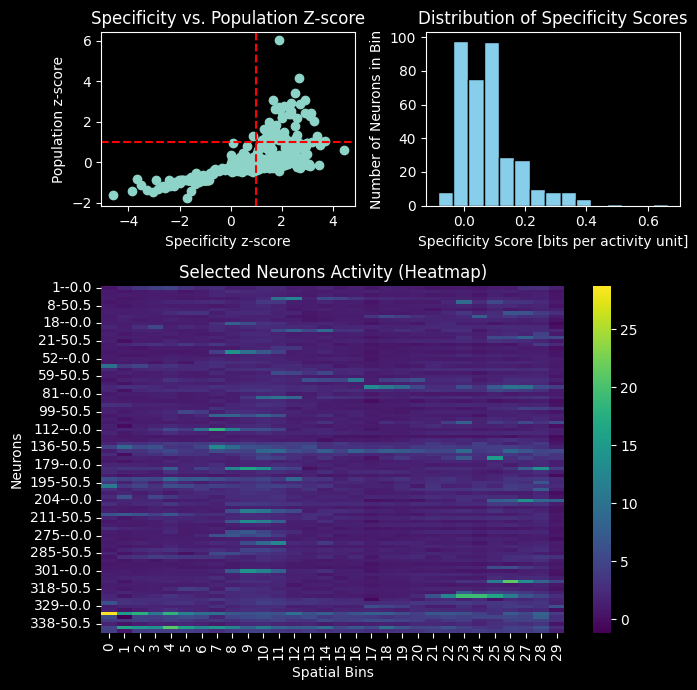

In [9]:
plt.style.use('dark_background')
# Create figure and GridSpec layout
fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 2])  # Two rows, two columns

# Subplot 1 (top left)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(spec_z_score_values, pop_z_score_values, 'o')
ax1.axhline(y=1, color='r', linestyle='--')
ax1.axvline(x=1, color='r', linestyle='--')
ax1.set_xlabel("Specificity z-score")
ax1.set_ylabel("Population z-score")
ax1.set_title("Specificity vs. Population Z-score")

# Subplot 2 (top right)
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(spatial_spec, bins=15, color='skyblue', edgecolor='black')
ax2.set_xlabel("Specificity Score [bits per activity unit]")
ax2.set_ylabel("Number of Neurons in Bin")
ax2.set_title("Distribution of Specificity Scores")

# Subplot 3 (bottom, spanning two columns)
ax3 = fig.add_subplot(gs[1, :])
sns.heatmap(avg_act_mtx[pop_z_score_values.loc[pop_z_score_values>1].index].T, cmap="viridis", ax=ax3, cbar=True)
ax3.set_title("Selected Neurons Activity (Heatmap)")
ax3.set_xlabel("Spatial Bins")
ax3.set_ylabel("Neurons")

# Adjust layout
plt.tight_layout()
#plt.savefig("spatial_specificity.svg")
plt.show()

16, 17, 55, 66, 74, 128, 135

- ID652, Dc_1: 2, 3, 4, 5, 12, 15, 17, 21, 43, 44

- ID652, Dc_2: 0, 8, 11, 23, 47, 49, 51, 52, 65, 66, 75, 76

- ID20240903 Dc_1: 6, 8, 13, 18, 20, 45, 59, 81, (99), 106, 112, 136 (anti-motion), 179, 210, 211, 232, (254), 275, 278, 285 (both), 292, 301, 311, 318, 320 (both),   

- ID20240916 Dc_1: 2, 3, 4, 5, 6, 12, 15, 42, 43, 44, 59

- ID20240916 Dc_2: 8, 47, 49, 65, 66

- ID20240930 alDl_1: NA

- ID20241011 alDl_1: NA

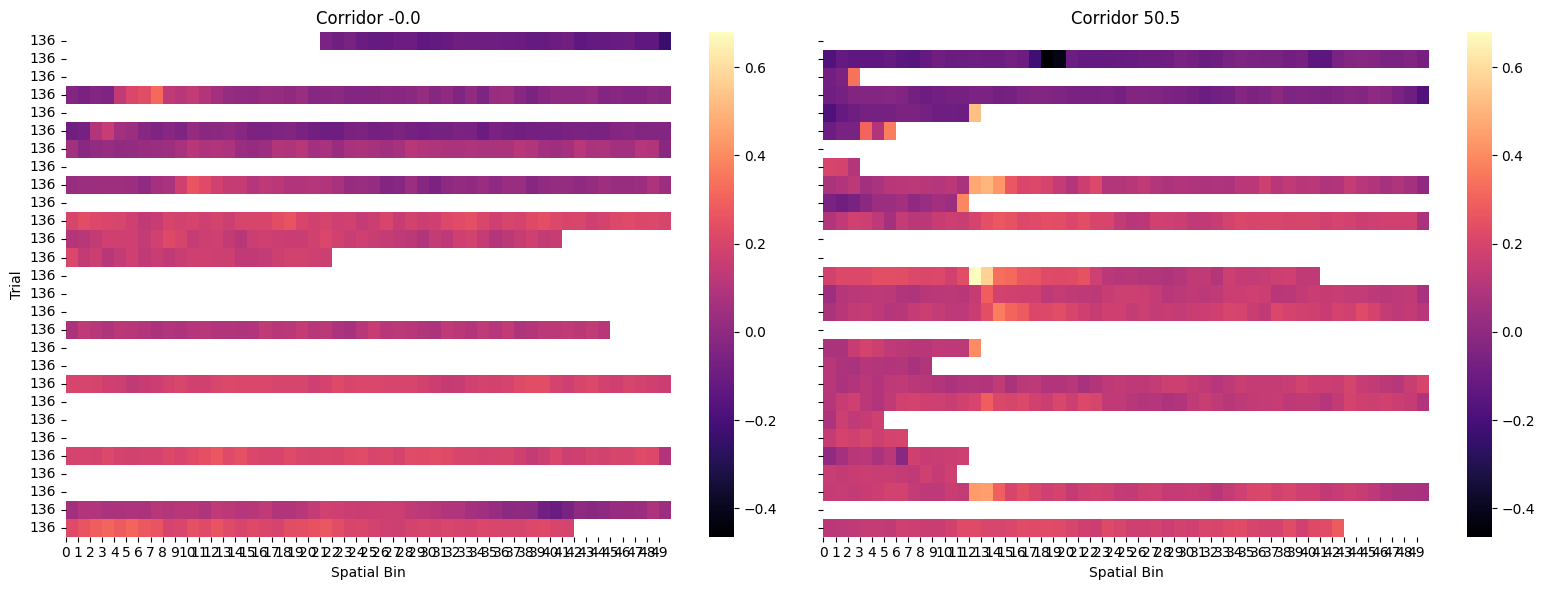

In [8]:
bh = add_trial_column(bh)
#trials_over_time(0, dff, bh, n_bins=30, export_figure=True) single field: # 6, 8, 18, 20, 45, 59, 81, 106, 
# 112, 210, 232, 254, 275, 278, 292, 301
# different fields in corridors: 42, 99
# different fields: 179
# fading field: 204, 211, 311, 318, 337, 346
# kinda similar fields: 285, 320
trials_over_time(136,  dff, bh, n_bins=50, export_figure=False)



# small fields 71, 74, 90, 92, 118, 121, 
# large fields 236, 238, 247, 266

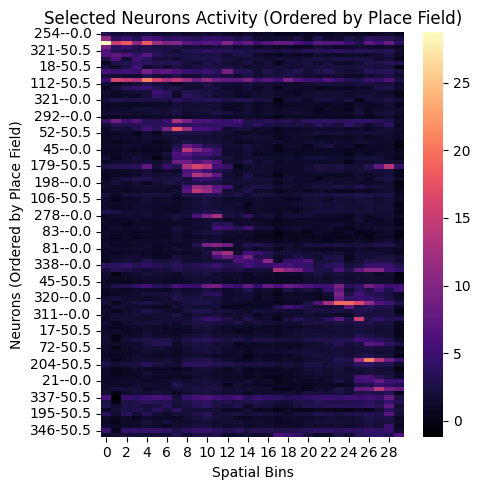

In [15]:
def plot_ordered_heatmap(avg_act_mtx, selected_neurons):
    '''
    Plots a heatmap of selected neurons, ordered by the location of their place fields.

    Parameters:
        avg_act_mtx (DataFrame): Average activity matrix (spatial bins x neurons).
        selected_neurons (list): List of neuron indices to include in the heatmap.
    '''

    # Step 1: Subset the DataFrame for selected neurons
    selected_data = avg_act_mtx[selected_neurons].T

    # Step 2: Determine the place field (peak activity) for each neuron
    place_fields = selected_data.idxmax(axis=1)

    # Step 3: Sort neurons based on the place field location
    sorted_neurons = place_fields.sort_values().index
    sorted_data = selected_data.loc[sorted_neurons]

    # Step 4: Plot the sorted heatmap
    plt.figure(figsize=(5, 5))
    sns.heatmap(sorted_data, cmap="magma", cbar=True)
    plt.title("Selected Neurons Activity (Ordered by Place Field)")
    plt.xlabel("Spatial Bins")
    plt.ylabel("Neurons (Ordered by Place Field)")
    plt.tight_layout()
    plt.show()

    
def plot_ordered_heatmaps_by_corridor(avg_act_mtx, selected_neurons, corridors=[0, 1]): # FIXME
    '''
    Plots two heatmaps of selected neurons, ordered by the location of their place fields for each corridor.

    Parameters:
        avg_act_mtx (DataFrame): Average activity matrix (spatial bins x neurons), with MultiIndex (Neuron, Corridor).
        selected_neurons (list): List of neuron indices to include in the heatmap.
        corridors (list): List of corridor indices to consider (default: [0, 1]).
    '''

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    corridor_names = avg_act_mtx.T.index.get_level_values('Corridor').unique().tolist()

    for i, corridor in enumerate(corridor_names):
        # Step 1: Subset the DataFrame for the selected corridor and neurons
        corridor_data = avg_act_mtx.T.xs(corridor, level='Corridor').T[selected_neurons]

        # Step 2: Determine the place field (peak activity) for each neuron
        place_fields = corridor_data.idxmax(axis=0)

        # Step 3: Sort neurons based on the place field location
        sorted_neurons = place_fields.sort_values().index
        sorted_data = corridor_data.T.loc[sorted_neurons]
        
        # Normalize Data
        # Normalize it by row:
        df_norm_row = sorted_data.apply(lambda x: (x-x.mean())/x.std(), axis = 0)
 

        # Step 4: Plot the sorted heatmap
        sns.heatmap(df_norm_row, cmap="magma", ax=axes[i], cbar=True, vmin=0)#, vmax=sorted_data.max().max())
        axes[i].set_title(f"Corridor {corridor}")
        axes[i].set_xlabel("Spatial Bins")
        axes[i].set_ylabel("Neurons (Ordered by Place Field)")

    plt.tight_layout()
    plt.show()
# Example usage:
# Assuming avg_act_mtx is your average activity matrix DataFrame
selected_neurons = pop_z_score_values.loc[pop_z_score_values>1].index  # Example neuron indices
plot_ordered_heatmap(avg_act_mtx, selected_neurons)

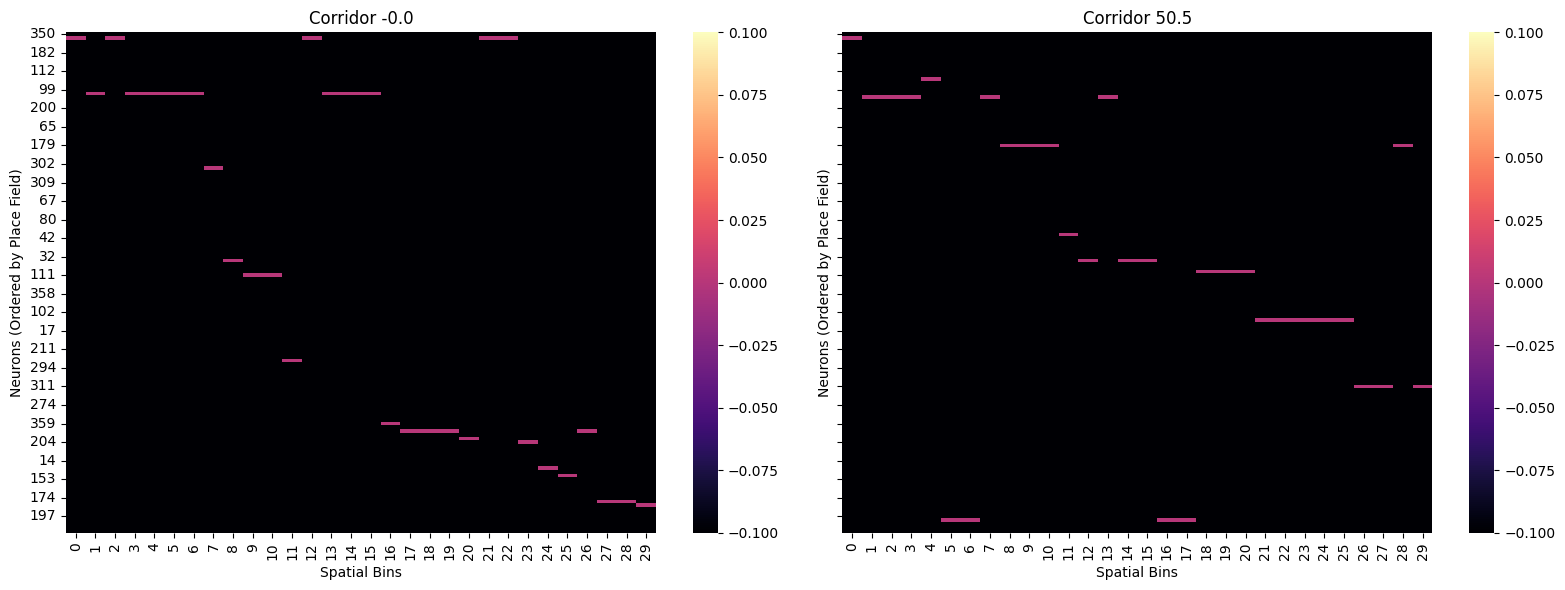

In [16]:
# Example usage:
# Assuming avg_act_mtx is your average activity matrix DataFrame
selected_neurons = pop_z_score_values.loc[pop_z_score_values>0].index  # Example neuron indices
plot_ordered_heatmaps_by_corridor(avg_act_mtx, selected_neurons)

The next step of the exploration is to look into "mixed-selectivity" neurons. In my superficial exploration, I found neurons that were both modulated by the position in the corridor (or, rather, which corridor the animal was in) and whether the animal was moving. 

It is common practice to showcase spatial selectivity of neurons by reading out the position of the animal based on population activity. 